In [117]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import requests
from skimage import io
import math

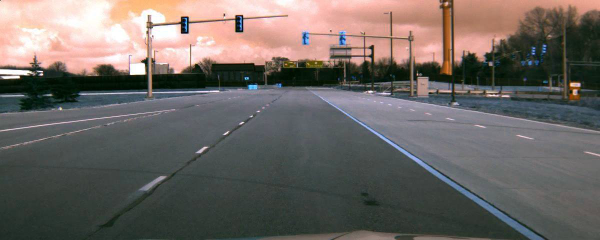

In [118]:
img_url = "https://raw.githubusercontent.com/kuowenyu/self-driving-car/feature-edits/computer-vision/first%20image.jpg"
img = io.imread(img_url)
width = int(img.shape[1] * 0.5)
height = int(img.shape[0] * 0.5)
dim = (width, height)
cv2_imshow(cv2.resize(img, dim))

In [119]:
def region_of_interest(img, vertices):
    # Define a blank matrix that matches the image height/width.
    mask = np.zeros_like(img)

    # Create a match color with the same color channel counts.
    match_mask_color = 255
      
    # Fill inside the polygon
    cv2.fillPoly(mask, vertices, match_mask_color)
    
    # Returning the image only where mask pixels match
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [120]:
# Convert to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [121]:
# Call Canny Edge Detection here
cannyed_img = cv2.Canny(gray_img, 100, 200)

In [122]:
# ROI definition
height = 480
width = 1200
min_y = 175
max_y = height - 20
region_of_interest_vertices = [(0, max_y), (width / 2, min_y), (width, max_y)]
cropped_img = region_of_interest(cannyed_img, np.array([region_of_interest_vertices], np.int32))

In [123]:
# Use Hough transforms to detect lines
lines = cv2.HoughLinesP(
    cropped_img,
    rho=6,
    theta=np.pi / 60,
    threshold=160,
    lines=np.array([]),
    minLineLength=40,
    maxLineGap=25
)

In [124]:
# Cluster segments of lines to left or right line
left_line_x = []
left_line_y = []
right_line_x = []
right_line_y = []

for line in lines:
    for x1, y1, x2, y2 in line:
        slope = float(y2 - y1) / (x2 - x1) # <-- Calculating the slope.
        if math.fabs(slope) < 0.5: # <-- Only consider extreme slope
            continue
        if slope <= 0: # <-- If the slope is negative, left group.
            left_line_x.extend([x1, x2])
            left_line_y.extend([y1, y2])
        else: # <-- Otherwise, right group.
            right_line_x.extend([x1, x2])
            right_line_y.extend([y1, y2])

In [125]:
# Least square fitting
# use first order polynomial to fit all the lines on the left
if not left_line_x or not right_line_x :
    line_img = img
else:
    poly_left = np.poly1d(np.polyfit(
        left_line_y,
        left_line_x,
        deg=1
    ))
    left_x_start = int(poly_left(max_y))
    left_x_end = int(poly_left(min_y))

    poly_right = np.poly1d(np.polyfit(
        right_line_y,
        right_line_x,
        deg=1
    ))

    right_x_start = int(poly_right(max_y))
    right_x_end = int(poly_right(min_y))

In [126]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    # If there are no lines to draw, exit.
    if lines is None:
        return

    # Make a copy of the original image.
    img = np.copy(img)

    # Create a blank image that matches the original in size.
    line_img = np.zeros(
        (
            img.shape[0],
            img.shape[1],
            3
        ),
        dtype=np.uint8,
    )
    # Loop over all lines and draw them on the blank image.
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)

    # Merge the image with the lines onto the original.
    img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)

    # Return the modified image.
    return img

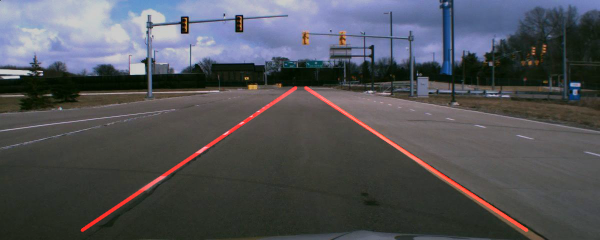

In [127]:
line_img = draw_lines(
        img, 
        [[
        [left_x_start, max_y, left_x_end, min_y],
        [right_x_start, max_y, right_x_end, min_y],
        ]],
        thickness = 5,
    )
real_img = cv2.cvtColor(line_img,cv2.COLOR_BGR2RGB)
cv2_imshow(cv2.resize(real_img, dim))